In [ ]:
# Auskommentieren für eine Installation von gym && gym-bandits in Google Colaboratory
#!pip install gym==0.23 gym-bandits==0.0.1 matplotlib==3.7.1

In [1]:
import os

import gym
import gym_bandits
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# show available OpenAI Gym environments
from gym import envs
print(envs.registry.all())

ValuesView(├──CartPole: [ v0, v1 ]
├──MountainCar: [ v0 ]
├──MountainCarContinuous: [ v0 ]
├──Pendulum: [ v1 ]
├──Acrobot: [ v1 ]
├──LunarLander: [ v2 ]
├──LunarLanderContinuous: [ v2 ]
├──BipedalWalker: [ v3 ]
├──BipedalWalkerHardcore: [ v3 ]
├──CarRacing: [ v1 ]
├──Blackjack: [ v1 ]
├──FrozenLake: [ v1 ]
├──FrozenLake8x8: [ v1 ]
├──CliffWalking: [ v0 ]
├──Taxi: [ v3 ]
├──Reacher: [ v2 ]
├──Pusher: [ v2 ]
├──InvertedPendulum: [ v2 ]
├──InvertedDoublePendulum: [ v2 ]
├──HalfCheetah: [ v2, v3 ]
├──Hopper: [ v2, v3 ]
├──Swimmer: [ v2, v3 ]
├──Walker2d: [ v2, v3 ]
├──Ant: [ v2, v3 ]
├──Humanoid: [ v2, v3 ]
├──HumanoidStandup: [ v2 ]
└──MultiarmedBandits: [ v0 ]
)


In [9]:
def epsilon_greedy(expParam, Q, arm_count, action_space):
    rand = np.random.random()
    if rand < expParam:
        action = action_space.sample()
    else:
        #action = action_space.start + np.argmax(Q)
        action = np.argmax(Q)
    return action

# TODO Uebung 2: implement logic
def get_softmax(q_vals, tau):
    exp_values = np.exp(q_vals / tau)
    probabilities = exp_values / np.sum(exp_values)
    # print(f"For Q-values {q_vals}, calculated softmax probabilities are {probabilities} with sum {np.sum(probabilities)}")
    return probabilities
    
def softmax (expParam, Q, arm_count, action_space): 
    prob = get_softmax(Q,expParam)
    return np.random.choice(range(action_space.n), p=prob)

# TODO Uebung 2: implement logic
def ucb (expParam, Q, arm_count, action_space): 
    # play each arm at least once 
    played_arms_counter = np.sum(arm_count)    
    ucb_values = Q / arm_count + expParam * np.sqrt((2 * np.log(played_arms_counter)) / arm_count)
    return np.argmax(ucb_values)
  
    
# TODO Uebung 3: implement custom exploration method. E.g. decay epsilon over time, or anything else 
def custom_method (expParam, Q, arm_count, action_space): 
    # ... 
    #return action_space.start # + ... 
    return # + ... 

In [13]:
# number of rounds (iterations)
num_plays = 1000
num_experiments = 1000
arms = 10

exploration_parameters = {
    'egreedy':  [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    'softmax':  [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2, 5, 10, 20, 100],
    'ucb':      [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2, 5, 10, 20, 100],
    'custom': [0]
}
expMemory = {
    'egreedy': {},
    'softmax': {},
    'ucb': {},
    'custom': {}
}
exploration_methods = {
    'egreedy': epsilon_greedy,
    'softmax': softmax, 
    'ucb': ucb, 
    #'custom': custom_method
}

<function epsilon_greedy at 0x121359990>, param=0


/var/folders/hf/5ypsk6yd5sqf01472x8_8kpc0000gn/T/ipykernel_34187/2543058569.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[arm] = Q[arm] + (reward - Q[arm]) / arm_count[arm]
/var/folders/hf/5ypsk6yd5sqf01472x8_8kpc0000gn/T/ipykernel_34187/2543058569.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rewards[i] = reward


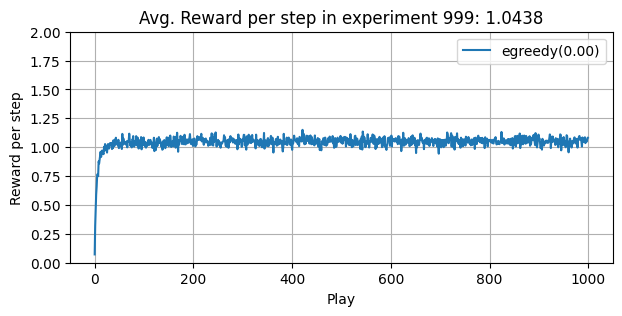

<function epsilon_greedy at 0x121359990>, param=0.01


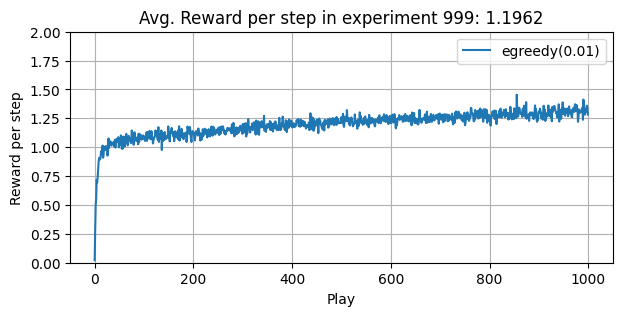

<function epsilon_greedy at 0x121359990>, param=0.05


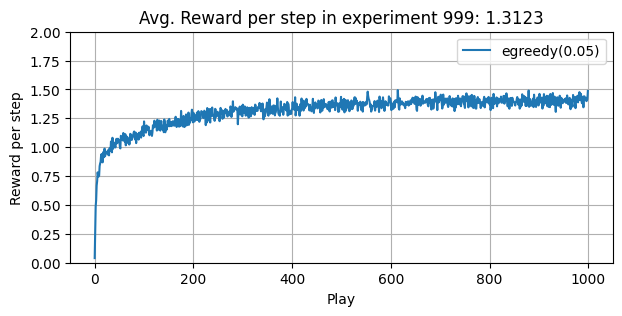

<function epsilon_greedy at 0x121359990>, param=0.1


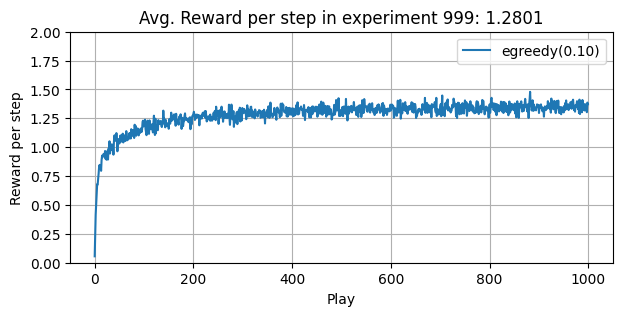

<function epsilon_greedy at 0x121359990>, param=0.2


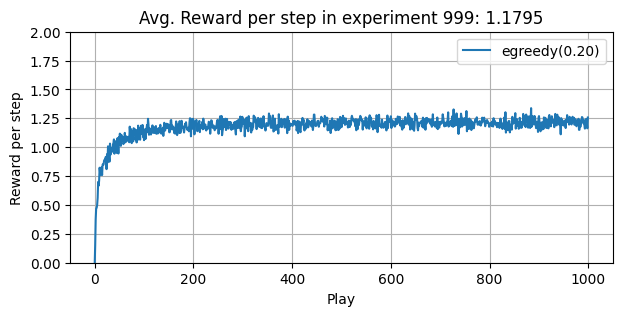

<function epsilon_greedy at 0x121359990>, param=0.5


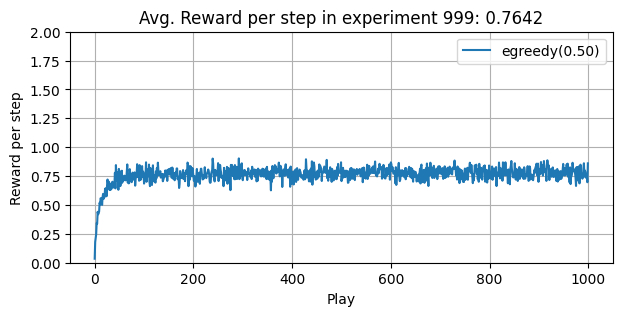

<function epsilon_greedy at 0x121359990>, param=1.0


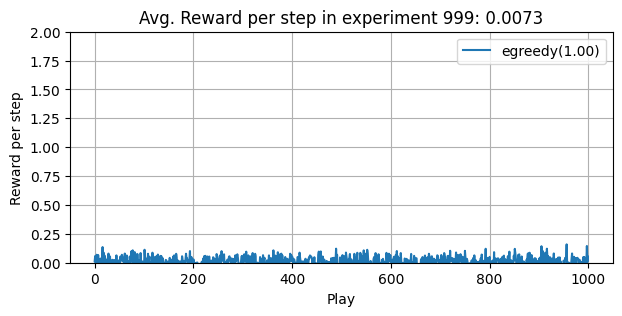

<function softmax at 0x120865d80>, param=0.01


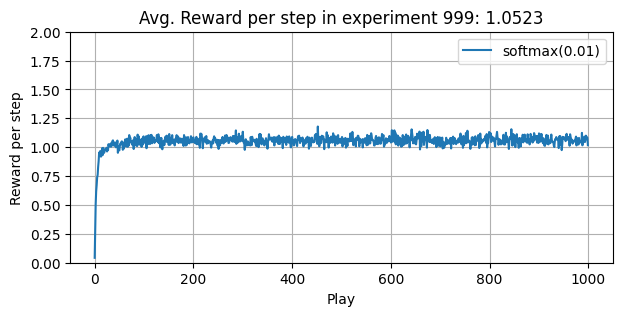

<function softmax at 0x120865d80>, param=0.05


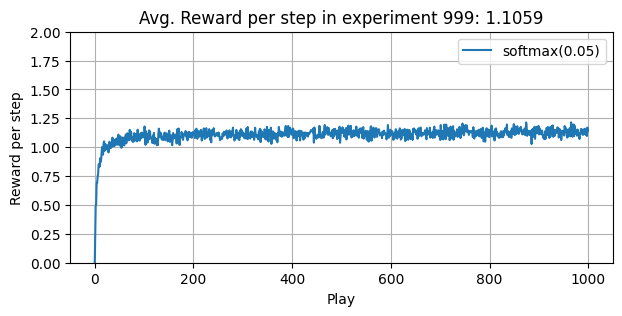

<function softmax at 0x120865d80>, param=0.1


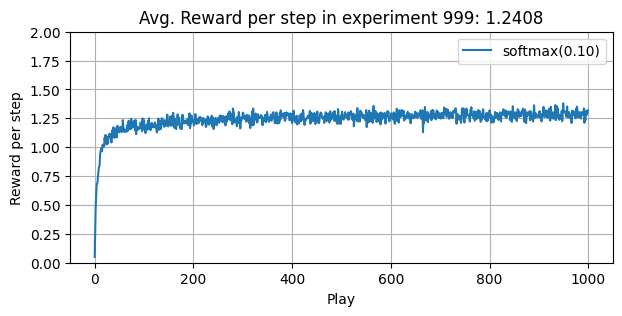

<function softmax at 0x120865d80>, param=0.2


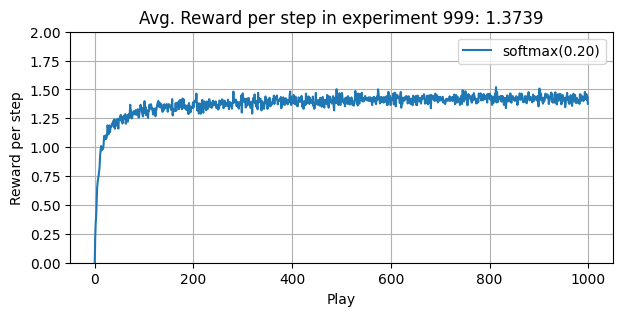

<function softmax at 0x120865d80>, param=0.5


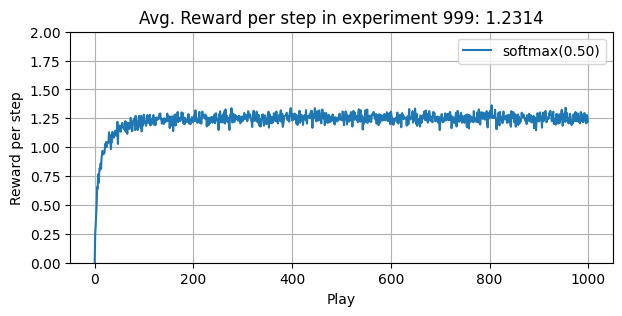

<function softmax at 0x120865d80>, param=1.0


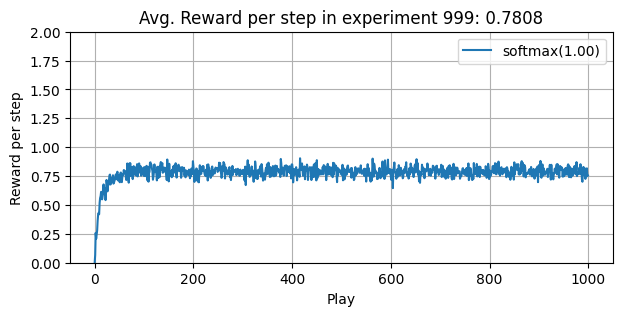

<function softmax at 0x120865d80>, param=2


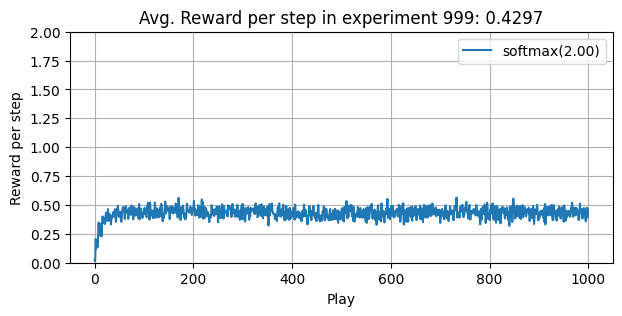

<function softmax at 0x120865d80>, param=5


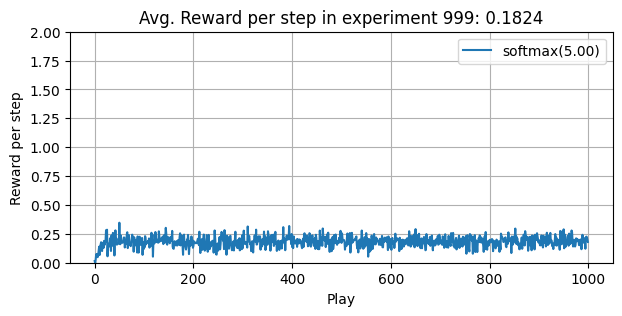

<function softmax at 0x120865d80>, param=10


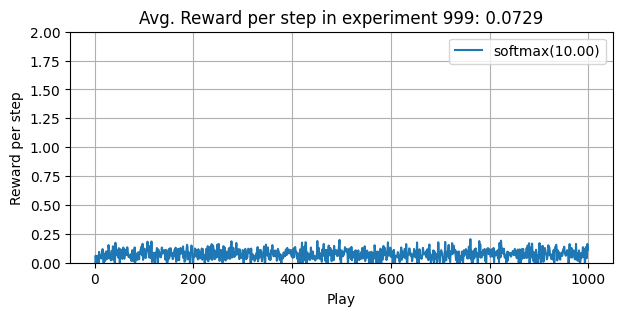

<function softmax at 0x120865d80>, param=20


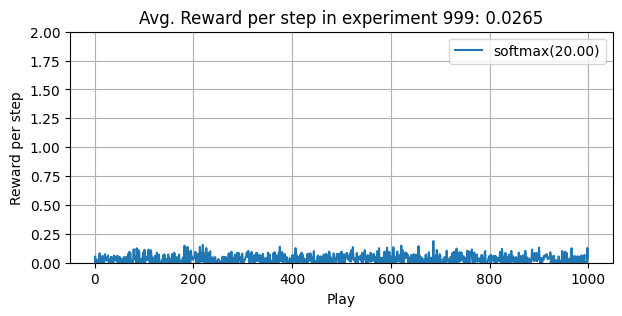

<function softmax at 0x120865d80>, param=100


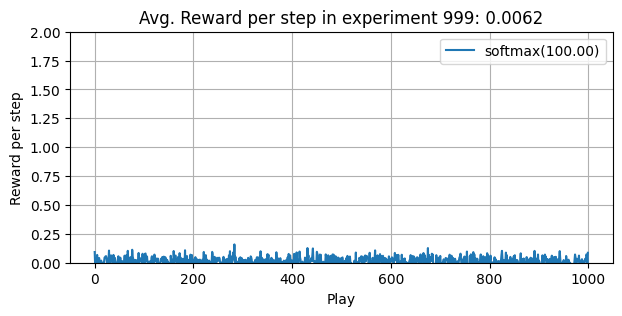

<function ucb at 0x120865a20>, param=0


/var/folders/hf/5ypsk6yd5sqf01472x8_8kpc0000gn/T/ipykernel_34187/3146506157.py:26: RuntimeWarning: invalid value encountered in divide
  ucb_values = Q / arm_count + expParam * np.sqrt((2 * np.log(played_arms_counter)) / arm_count)
/var/folders/hf/5ypsk6yd5sqf01472x8_8kpc0000gn/T/ipykernel_34187/3146506157.py:26: RuntimeWarning: divide by zero encountered in log
  ucb_values = Q / arm_count + expParam * np.sqrt((2 * np.log(played_arms_counter)) / arm_count)
/var/folders/hf/5ypsk6yd5sqf01472x8_8kpc0000gn/T/ipykernel_34187/3146506157.py:26: RuntimeWarning: invalid value encountered in sqrt
  ucb_values = Q / arm_count + expParam * np.sqrt((2 * np.log(played_arms_counter)) / arm_count)
/var/folders/hf/5ypsk6yd5sqf01472x8_8kpc0000gn/T/ipykernel_34187/3146506157.py:26: RuntimeWarning: divide by zero encountered in divide
  ucb_values = Q / arm_count + expParam * np.sqrt((2 * np.log(played_arms_counter)) / arm_count)
/var/folders/hf/5ypsk6yd5sqf01472x8_8kpc0000gn/T/ipykernel_34187/3146506157

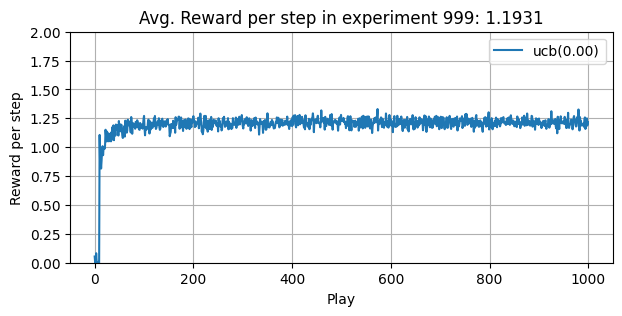

<function ucb at 0x120865a20>, param=0.01


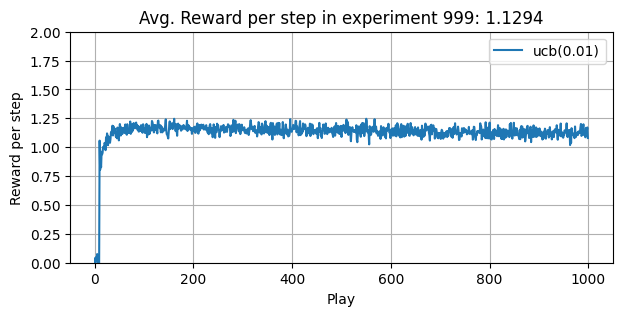

<function ucb at 0x120865a20>, param=0.05


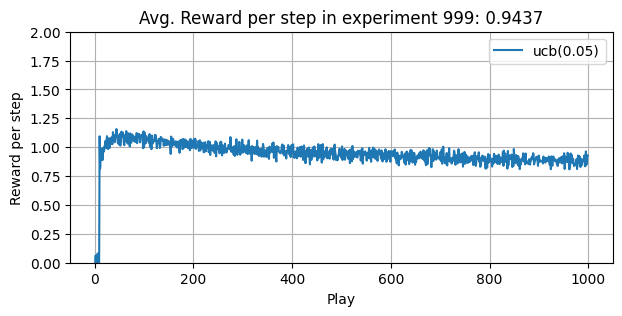

<function ucb at 0x120865a20>, param=0.1


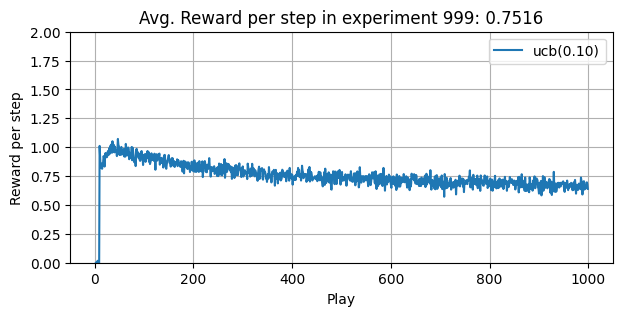

<function ucb at 0x120865a20>, param=0.2


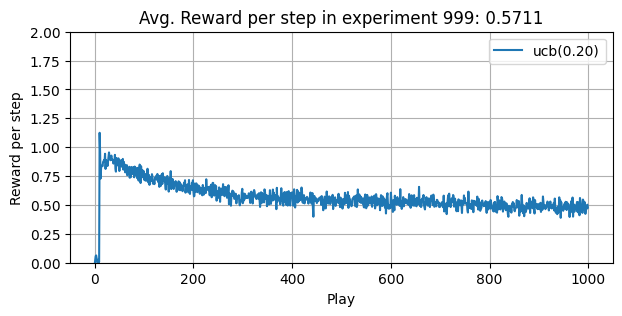

<function ucb at 0x120865a20>, param=0.5


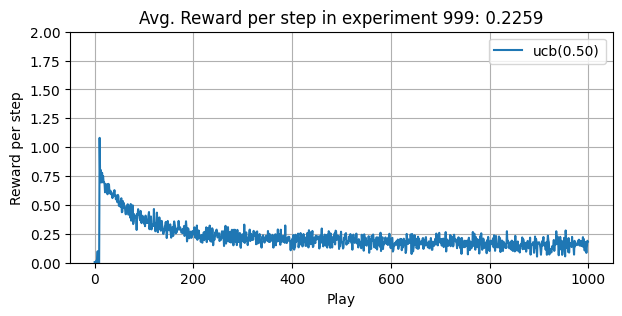

<function ucb at 0x120865a20>, param=1.0


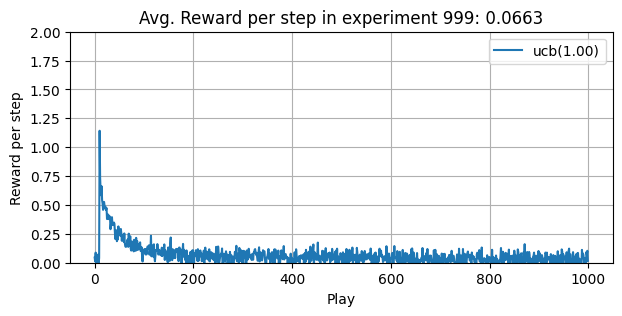

<function ucb at 0x120865a20>, param=2


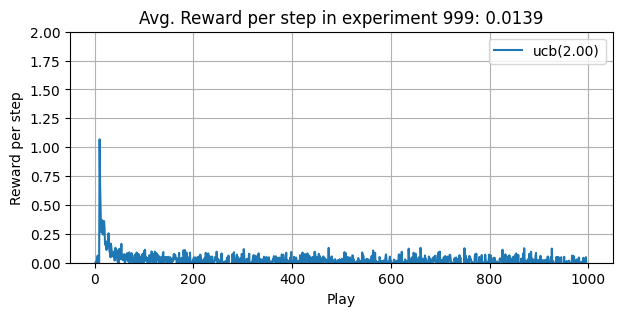

<function ucb at 0x120865a20>, param=5


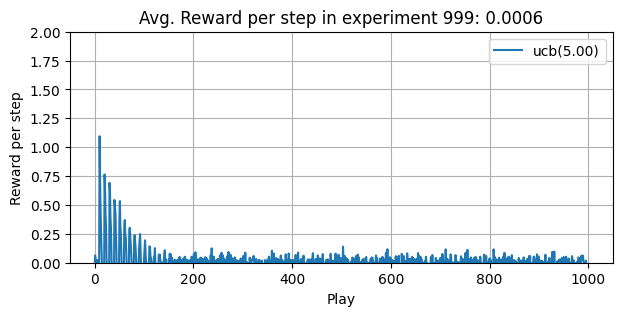

<function ucb at 0x120865a20>, param=10


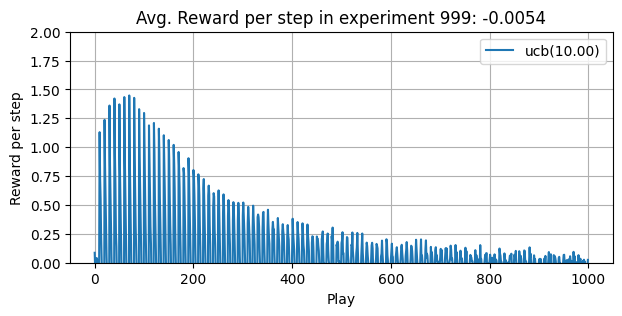

<function ucb at 0x120865a20>, param=20


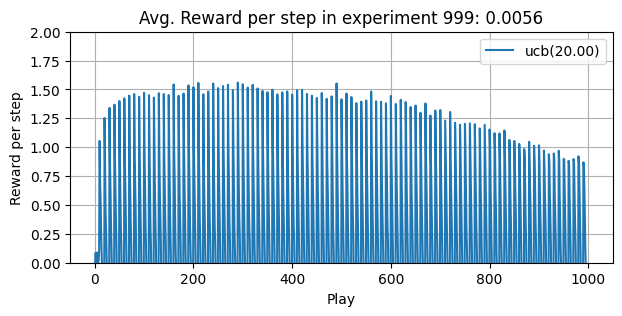

<function ucb at 0x120865a20>, param=100


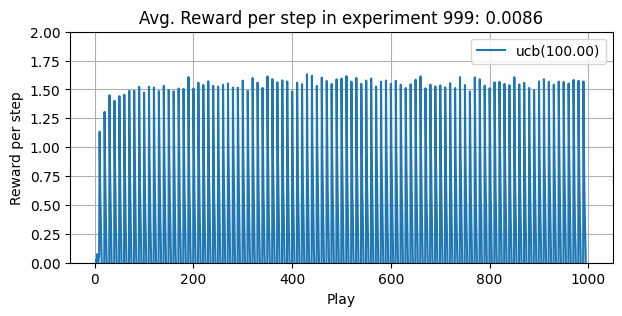

In [17]:
plots_base_path = os.path.join(os.path.curdir, 'plots')
experiments_base_path = os.path.join(plots_base_path, 'experiments')
os.makedirs(plots_base_path, exist_ok=True)
os.makedirs(experiments_base_path, exist_ok=True)

#######################
# conduct experiment
#######################
# exploration_parameters = exp_greedy
for method_name in exploration_methods.keys():
    
    exp_method = exploration_methods[method_name]
    
    for expParam in exploration_parameters[method_name]:
        
        print (f"{exp_method}, param={expParam}")
        
        # memorize all rewards of all episodes in rewardMemory for statistic plotting
        rewardMemory = []
    
        for e in range(num_experiments):

            # create new instance of bandit environment
            env = gym.make("MultiarmedBandits-v0")
            env.reset()

            # count of number of times an arm was pulled
            arm_count = np.zeros(arms)
            # Q value => expected average reward
            Q = np.zeros(arms)
            rewards = np.zeros(num_plays)

            for i in range(num_plays):
                # select action (exploration/exploitation)
                arm = exp_method(expParam=expParam, Q=Q, arm_count=arm_count, action_space=env.action_space)

                # get reward/observation/terminalInfo
                observation, reward, done, info = env.step(arm)
                
                # update the count of that arm
                arm_count[arm] += 1
                
                # TODO Uebung 1: recalculate its Q value
                Q[arm] = Q[arm] + (reward - Q[arm]) / arm_count[arm]
                
                # memorize rewards per play
                rewards[i] = reward

            # memorize reward array
            rewardMemory.append(rewards)

            ###################
            # Plotting results
            ###################
            if e == (num_experiments-1):

                means = np.mean(rewardMemory, axis=0)

                # plot average reward
                plt.figure(figsize=(7,3))
                plt.plot(means, label="%s(%.2f)" % (method_name, expParam))
                
                plt.ylim(0, 2) # limit y axis
                plt.title('Avg. Reward per step in experiment %d: %.4f' % (e, sum(means) / num_plays))
                plt.ylabel("Reward per step")
                plt.xlabel("Play")
                plt.legend()
                method_path = os.path.join(experiments_base_path, method_name)
                os.makedirs(method_path, exist_ok=True)
                plt.grid()
                plt.savefig(os.path.join(method_path, f'{method_name}_expParam_{expParam}_experiment_{e}.png'))
                plt.show()

        #expMemory[method_name] |= { expParam: rewardMemory }
        expMemory[method_name][expParam] = rewardMemory


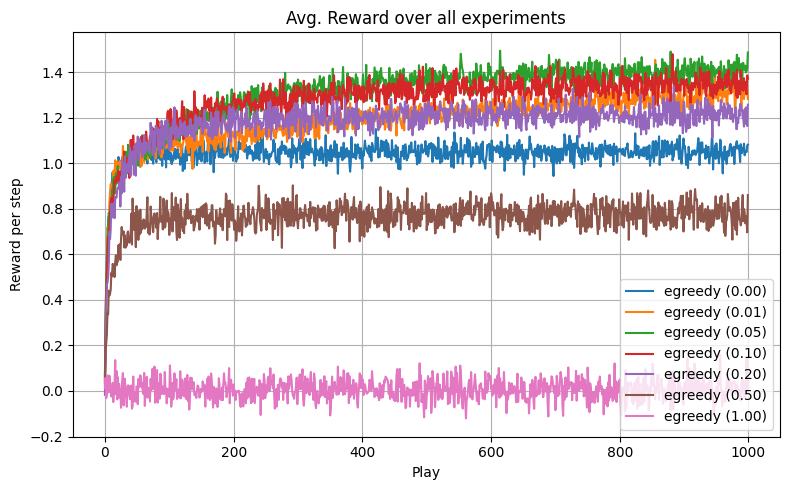

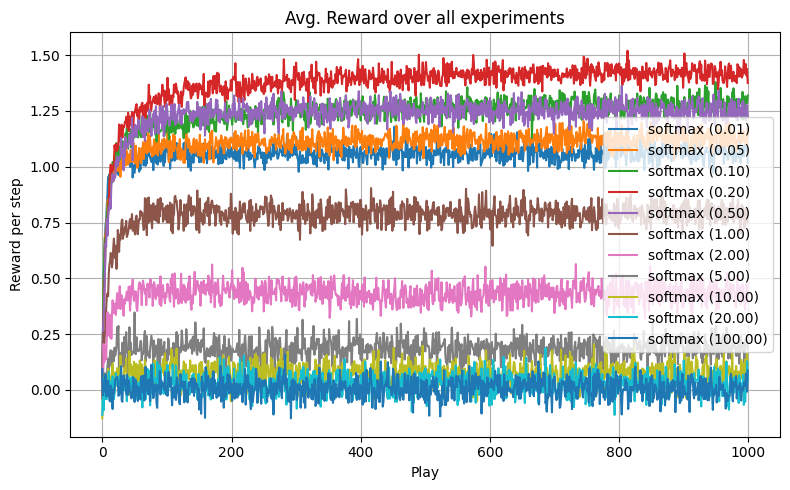

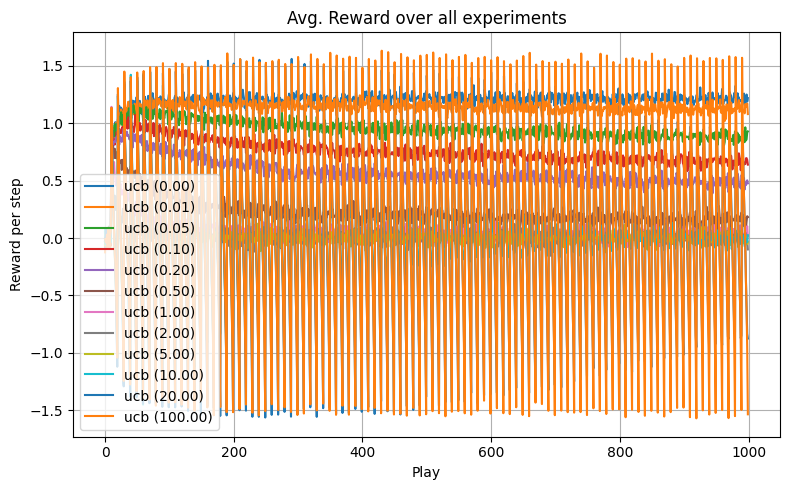

In [18]:
"""
Die Mittelwerte über jeweils 1000 Experimente sollen in einem Graph dargestellt werden
"""
#sns.set_theme(style='white')
for method_name in exploration_methods.keys():
    _ = plt.figure(figsize=(8, 5))
    plt.set_cmap('Set3')
    for expParam, memory in expMemory[method_name].items():
        means = np.mean(memory, axis=0)
        plt.plot(means, label=f'{method_name} ({expParam:.2f})')

    plt.grid()
    plt.xlabel('Play')
    plt.ylabel('Reward per step')
    plt.title('Avg. Reward over all experiments')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(plots_base_path, f'{method_name}.png'))
    plt.show()

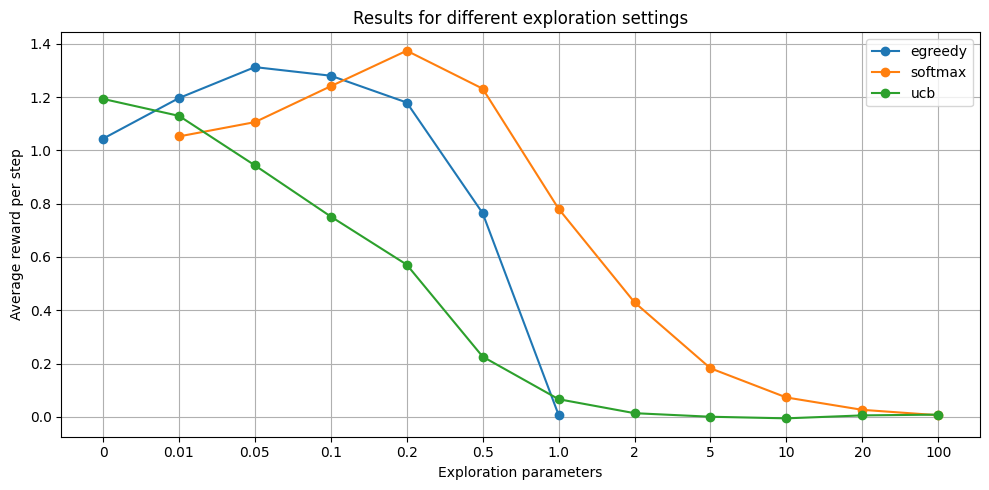

In [19]:
"""
Was sind gute Parameter, was sind schlechte Parameter?
Belegen Sie Ihre Aussage mit statistischen Auswertungen.
Erstellen Sie einen Scatter-Plot der Ergebnisse aller drei
Explorationsverfahren nach folgenden Vorgaben:

X-Achse: Explorationsparameter des jeweiligen Explorationsverfahrens

Y-Achse: durchschnittlicher Reward pro Schritt in einer Episode der
         Länge von 1000 Schritten, gemittelt über 1000 Experimente.
"""
_ = plt.figure(figsize=(10, 5))
for method_name in exploration_methods.keys():
    x, y = [], []
    for expParam, experiments_rewards in expMemory[method_name].items():
        x.append(str(expParam))
        play_means = []
        for plays_rewards in experiments_rewards:
            play_means.append(np.mean(plays_rewards))
        y.append(np.mean(play_means))
    plt.plot(x, y, linestyle="-", marker="o", label=method_name)

plt.grid()
plt.xlabel('Exploration parameters')
plt.ylabel('Average reward per step')
plt.title('Results for different exploration settings')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_base_path, 'aggregated.png'))
plt.show()